In [1]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCTE_BRB_Data_Analysis"))
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/nHits_trigger"))
sys.path.append('/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/hipy')
sys.path.append("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCTE_event_display")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data import load_concatenated, read_parquet, nHits
from tqdm          import tqdm
from EventDisplay  import EventDisplay

%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [2]:
# ============= LOADS THE DATA ===================
bkg_run  = 1766
bkg_data = load_concatenated(outdir=f"/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/processed_wcte_data/{bkg_run}_1_calibrated_tof_good")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
bkg_run_cards, bkg_run_channels, bkg_run_slots, bkg_run_positions, bkg_run_times, bkg_run_events, bkg_run_charges, bkg_run_window_times = read_parquet(bkg_data, mask=True)
print("Data Masked")

bkg_run_times_sorted = ak.sort(bkg_run_times) - bkg_run_window_times
bkg_run_window_times_sorted = ak.sort(bkg_run_window_times, axis=0)

Data Loaded
Data Masked


In [3]:
# ============= LOADS THE DATA ===================
nicf_run  = 1767
nicf_data = load_concatenated(outdir=f"/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/processed_wcte_data/{nicf_run}_1_calibrated_tof_good")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
nicf_run_cards, nicf_run_channels, nicf_run_slots, nicf_run_positions, nicf_run_times, nicf_run_events, nicf_run_charges, nicf_run_window_times = read_parquet(nicf_data, mask=True)
print("Data Masked")

nicf_run_times_sorted = ak.sort(nicf_run_times) - nicf_run_window_times
nicf_run_window_times_sorted = ak.sort(nicf_run_window_times, axis=0)

Data Loaded
Data Masked


# nHits To Find Spills and AfterPulsing

In [4]:
bkg__triggered_spill_hits_index, bkg__triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)
nicf_triggered_spill_hits_index, nicf_triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=nicf_run_times_sorted, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

100%|██████████| 11113/11113 [00:02<00:00, 3735.01it/s]


### Remove Spills from data

In [5]:
def remove_spill(trigger_indices, run_times):
    corrected_run_times = []

    for i in tqdm(range(len(run_times))):
        if i in trigger_indices:
            #Event with spill → remove selected indices
            data = run_times[i]
            trigger_indices_event = np.concatenate(trigger_indices[i])
            all_indices           = np.arange(len(data))
            valid_indices         = np.setdiff1d(all_indices, trigger_indices_event)
            corrected_run_times.append(data[valid_indices])
        else:
            # Event without spill → leave as it is
            corrected_run_times.append(run_times[i])

    return ak.Array(corrected_run_times)

In [6]:
bkg__corrected_run_times_sorted = remove_spill(bkg__triggered_spill_hits_index, bkg_run_times_sorted)
nicf_corrected_run_times_sorted = remove_spill(nicf_triggered_spill_hits_index, nicf_run_times_sorted)

100%|██████████| 11113/11113 [00:02<00:00, 5450.41it/s]


In [7]:
bkg__corrected_no_hits_per_bin_50ns = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 500e3, 50))[0] for ev in tqdm(range(200), total=200)])
nicf_corrected_no_hits_per_bin_50ns = np.concatenate([np.histogram(nicf_corrected_run_times_sorted[ev], np.arange(0, 500e3, 50))[0] for ev in tqdm(range(200), total=200)])

100%|██████████| 200/200 [00:09<00:00, 20.86it/s]


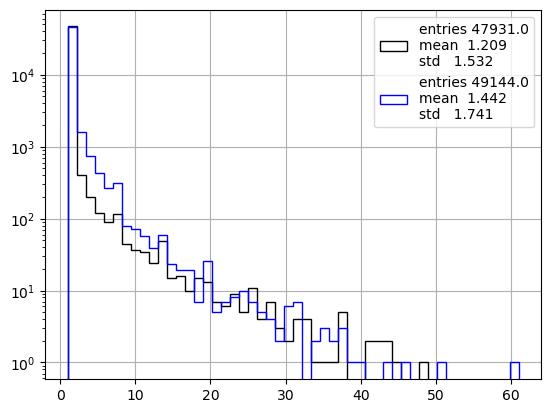

In [8]:
pltext.hist(bkg__corrected_no_hits_per_bin_50ns, 50, ylog=True, range=(1, np.max(nicf_corrected_no_hits_per_bin_50ns)));
pltext.hist(nicf_corrected_no_hits_per_bin_50ns, 50, ylog=True, range=(1, np.max(nicf_corrected_no_hits_per_bin_50ns)));

# N50 Clusterization

### New nHits

In [11]:
# Modified nHits
def nHits(mode, hit_times, w, thresh_min, thresh_max, pre_window, post_window, jump, event=0, progress_bar=True):
    
    # SINGLE EVENT MODE
    if mode=="single_event":
        triggered_hits_index = {}
        triggered_hits_time  = {}

        ht = ak.to_numpy(hit_times[event])

        # Sliding window logic
        ends   = ht + w
        right  = np.searchsorted(ht, ends, side="left")
        left   = np.arange(len(ht))
        counts = right - left

        # Get the indices of all the hit times that triggered the nHits algorithm
        trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]

        event_hits = []
        event_hit_times = []
        last_trigger_time = -np.inf  # First trigger always need to exist

        # Search for the rest of the hits in the trigger
        for idx in trigger_indices:
            last_idx = idx
            while last_idx < len(ht) - 1:
                if ht[last_idx + 1] - ht[last_idx] < 50:
                    last_idx += 1
                else:
                    break
            window_hits = ht[idx:last_idx + 1]

            first_hit_time = window_hits[0]
            last_hit_time  = window_hits[-1]

            # Avoid overlap due to dead time
            if first_hit_time < last_trigger_time + jump:
                continue

            # Expand window
            t_min = first_hit_time - pre_window
            t_max = last_hit_time + post_window

            indices_in_window   = np.where((ht >= t_min) & (ht <= t_max))[0]
            hit_times_in_window = ht[(ht >= t_min) & (ht <= t_max)]
            event_hits.append(indices_in_window)
            event_hit_times.append(hit_times_in_window)

            idx = last_idx + 1

        # Update dictionary
        if len(event_hits) > 0:
            triggered_hits_index[event] = event_hits
            triggered_hits_time[event]  = event_hit_times

    # MULTIPLE EVENTS MODE
    elif mode == "multiple_events":
        nevents = len(hit_times)
        triggered_hits_index = {}
        triggered_hits_time  = {}

        for event in tqdm(range(nevents), total=nevents, leave=progress_bar):
            ht = ak.to_numpy(hit_times[event])
            if len(ht) == 0:
                continue
            
            # Sliding window logic
            ends   = ht + w
            right  = np.searchsorted(ht, ends, side="left")
            left   = np.arange(len(ht))
            counts = right - left

            # Get the indices of all the hit times that triggered the nHits algorithm
            trigger_indices = np.where((counts >= thresh_min) & (counts < thresh_max))[0]
            if len(trigger_indices) == 0: # Skip if no triggers in event
                continue

            event_hits = []
            event_hit_times = []
            last_trigger_time = -np.inf  # First trigger always need to exist

            # Search for the rest of the hits in the trigger
            for idx in trigger_indices:
                last_idx = idx
                while last_idx < len(ht) - 1:
                    if ht[last_idx + 1] - ht[last_idx] < 50:
                        last_idx += 1
                    else:
                        break
                window_hits = ht[idx:last_idx + 1]

                first_hit_time = window_hits[0]
                last_hit_time  = window_hits[-1]

                # Avoid overlap due to dead time
                if first_hit_time < last_trigger_time + jump:
                    continue

                # Expand window
                t_min = first_hit_time - pre_window
                t_max = last_hit_time + post_window

                indices_in_window = np.where((ht >= t_min) & (ht <= t_max))[0]
                hit_times_in_window = ht[(ht >= t_min) & (ht <= t_max)]
                event_hits.append(indices_in_window)
                event_hit_times.append(hit_times_in_window)

                idx = last_idx + 1

            # Update dictionary
            if len(event_hits) > 0:
                triggered_hits_index[event] = event_hits
                triggered_hits_time[event]  = event_hit_times
    else:
        print("enter a valid mode name")

    return triggered_hits_index, triggered_hits_time

### Actual Clusterization

In [9]:
for i in tqdm(range(2,8), total=len(range(2,8))):
    thresh = i

    # nHits
    bkg__triggered_signal_hits_index, bkg__triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted, w=50, thresh_min=thresh, thresh_max=thresh+1, pre_window=0, post_window=0, jump=50)
    nicf_triggered_signal_hits_index, nicf_triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=nicf_corrected_run_times_sorted, w=50, thresh_min=thresh, thresh_max=thresh+1, pre_window=0, post_window=0, jump=50)

    # tRMS
    bkg__rms_50ns = []
    for k,v in tqdm(bkg__triggered_signal_hit_times.items(), total=len(bkg__triggered_signal_hit_times.items()), leave=False):
            for i in bkg__triggered_signal_hit_times.get(k):
                bkg__rms_50ns.append(np.std(i, ddof=0))

    nicf_rms_50ns = []
    for k,v in tqdm(nicf_triggered_signal_hit_times.items(), total=len(nicf_triggered_signal_hit_times.items()), leave=False):
            for i in nicf_triggered_signal_hit_times.get(k):
                nicf_rms_50ns.append(np.std(i, ddof=0))

    # Plots
    pltext.hist(bkg__rms_50ns, 100, xylabels="$t_{RMS}$");
    pltext.hist(nicf_rms_50ns, 100, xylabels="$t_{RMS}$");
    plt.title(f"N50 = {thresh}");
    plt.savefig(f"figures/N50{thresh}.pdf")
    plt.close()

100%|██████████| 6/6 [00:57<00:00,  9.63s/it]


100%|██████████| 11113/11113 [00:03<00:00, 3281.92it/s]


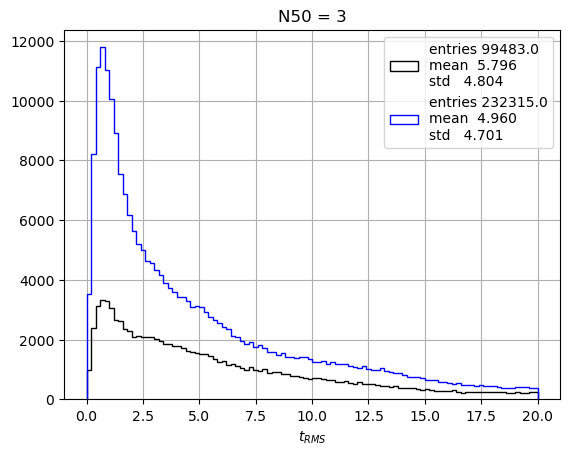

In [14]:
thresh = 3

# nHits
bkg__triggered_signal_hits_index, bkg__triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted, w=50, thresh_min=thresh, thresh_max=thresh+1, pre_window=0, post_window=0, jump=50)
nicf_triggered_signal_hits_index, nicf_triggered_signal_hit_times = nHits(mode="multiple_events", hit_times=nicf_corrected_run_times_sorted, w=50, thresh_min=thresh, thresh_max=thresh+1, pre_window=0, post_window=0, jump=50)

# tRMS
bkg__rms_50ns = []
for k,v in tqdm(bkg__triggered_signal_hit_times.items(), total=len(bkg__triggered_signal_hit_times.items()), leave=False):
        for i in bkg__triggered_signal_hit_times.get(k):
            bkg__rms_50ns.append(np.std(i, ddof=0))

nicf_rms_50ns = []
for k,v in tqdm(nicf_triggered_signal_hit_times.items(), total=len(nicf_triggered_signal_hit_times.items()), leave=False):
        for i in nicf_triggered_signal_hit_times.get(k):
            nicf_rms_50ns.append(np.std(i, ddof=0))

# Plots
pltext.hist(bkg__rms_50ns, 100, range=(0,20), xylabels="$t_{RMS}$");
pltext.hist(nicf_rms_50ns, 100, range=(0,20), xylabels="$t_{RMS}$");
plt.title(f"N50 = {thresh}");

# Final Data Selection: $t_{RMS} < 2$ ns N50 $\le$ 20 hits

# ReWriter Of Data So We Can Feed BONSAI With It